# Expectation maximisation for changepoint detection

Consider time series data where each sample is drawn from one of two normal distributions based on its time index. A changepoint exists within the data and the mean and standard deviations of the two distributions are different.

$N$ samples are drawn and the samples $x_i$ where $0 \le i < N$ are assumed to be IID. 

The likelihood of the data is given by:

$$
L(\theta; x) = \prod_{i=1}^N p(x_i | \theta)
$$

There is a changepoint at index $k$. The probability of a given sample $x_i$ is given by

$$ p(x_i | \theta) =   \left\{
\begin{array}{ll}
      p(x_i | \mu_0, \sigma_0) & i < k \\
      p(x_i | \mu_1, \sigma_1) & i \ge k \\
\end{array} 
\right.  
$$

The log-likelihood is given by

$$
\log L(\theta; x) = \sum_{i=1}^N \log p(x_i | \theta)
$$

The algorithm for determining the parameters of the normal distributions $\{\mu_0, \sigma_0, \mu_1, \sigma_1\}$ and the changepoint $k$ involves two interwoven steps.

1. Given $\{\mu_0, \sigma_0, \mu_1, \sigma_1\}$ calculate the value of $k$ that maximises the log-likelihood.

2. Given the changepoint $k$, calculate the parameters of the two distributions.

The parameters of the distributions are given by:

$$
\mu_0 = \frac{1}{k} \sum_{i=0}^{k-1} x_i
$$

$$
\sigma_0 = \sqrt{ \frac{1}{k} \sum_{i=0}^{k} (x_i - \mu_0)^2 }
$$

$$
\mu_1 = \frac{1}{N-k+1} \sum_{i=k}^{N-1} x_i
$$

$$
\sigma_1 = \sqrt{ \frac{1}{N-k+1} \sum_{i=k}^{N} (x_i - \mu_0)^2 }
$$

## Generate data

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from scipy import stats

In [2]:
# Number of samples
N = 100

# Parameters for the two phases
mu = [2.0, 5.0]
sigma = [0.5, 0.25]

# Changepoint
k = 34

In [3]:
# Normal distributions for each phase
d1 = stats.norm(mu[0], sigma[0])
d2 = stats.norm(mu[1], sigma[1])

x = np.zeros(N)

for i in range(N):
    if i < k:
        x[i] = d1.rvs()
    else:
        x[i] = d2.rvs()

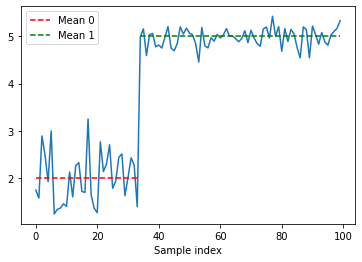

In [4]:
plt.plot(x)
plt.plot(np.arange(k), np.repeat(mu[0], k), '--r', label='Mean 0')
plt.plot(np.arange(k, N), np.repeat(mu[1], N-k), '--g', label='Mean 1')
plt.legend()
plt.xlabel('Sample index')
plt.show()

## Expectation maximisation

In [5]:
def calc_log_likelihood(x, mu, sigma, k):
    """Calculate the log-likelihood of the samples."""
    
    # Preconditions
    assert len(x) > 1
    assert len(mu) == 2
    assert len(sigma) == 2
    assert 0 <= k < len(x)
    
    # Normal distributions for each phase
    d1 = stats.norm(mu[0], sigma[0])
    d2 = stats.norm(mu[1], sigma[1])

    # Calculate the log-likelihood
    log_likelihood = 0
    for i in range(len(x)):
        
        if i < k:
            p = d1.pdf(x[i])
        else:
            p = d2.pdf(x[i])
        
        p = max(p, np.finfo(float).eps)
        
        log_likelihood += np.log(p)
    
    return log_likelihood

In [6]:
def k_maximises_log_likelihood(x, mu, sigma):
    """Find the value of k that maximises the log-likelihood."""
    
    # Preconditions
    assert len(x) > 1
    assert len(mu) == 2
    assert len(sigma) == 2

    # Number of samples
    N = len(x)
    
    # Potential sites of the changepoint
    k = np.arange(1, N-1)
    
    # Calculate the log-likelihoods for each value of k
    log_likelihoods = [calc_log_likelihood(x, mu, sigma, ki) for ki in k]
    
    # Find the index that maximises the log-likelihood
    idx = np.argmax(log_likelihoods)
    
    # Return the value of k that maximises the log-likelihood
    return k[idx]

In [7]:
def estimate_mu_sigma(x, k):
    """Estimate mu, sigma based on the changepoint."""
    
    # Preconditions
    assert len(x) > 1
    assert 0 <= k < len(x)
    
    mu = np.mean(x[:k]), np.mean(x[k:])
    sigma = np.std(x[:k]), np.std(x[k:])
    
    return mu, sigma

In [8]:
# Initial parameters
mu_est = [2.5, 3.5]
sigma_est = [0.5, 0.5]

In [9]:
stop_condition_met = False
n_iterations = 0
max_iterations = 20

log_likelihoods = []

while not stop_condition_met:

    n_iterations += 1
    
    # Choose value of k that maximises the log-likelihood
    k_est = k_maximises_log_likelihood(x, mu_est, sigma_est)

    # Update mu, sigma based on the changepoint
    mu_est, sigma_est = estimate_mu_sigma(x, k_est)

    # Calculate the log-likelihood
    log_likelihoods.append(calc_log_likelihood(x, mu_est, sigma_est, k_est))

    if n_iterations > 1:
        diff = np.abs(log_likelihoods[-1] - log_likelihoods[-2])
        stop_condition_met = diff < 1e-3
        if stop_condition_met:
            print(f"Converged after {n_iterations} iterations")
    
    if n_iterations == max_iterations:
        stop_condition_met = True
        print(f"Failed to converge after {n_iterations} iterations")

Converged after 2 iterations


In [10]:
k_est

34

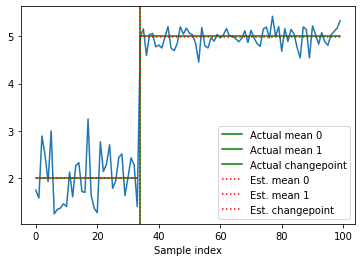

In [11]:
# Plot the data points
plt.plot(x)

# Plot the actual means and changepoint
plt.plot(np.arange(k), np.repeat(mu[0], k), '-g', label='Actual mean 0')
plt.plot(np.arange(k, N), np.repeat(mu[1], N-k), '-g', label='Actual mean 1')
plt.axvline(x=k, color='g', linestyle='-', label="Actual changepoint")

# Plot the estimated means and changepoint
plt.plot(np.arange(k_est), np.repeat(mu_est[0], k_est), ':r', label='Est. mean 0')
plt.plot(np.arange(k_est, N), np.repeat(mu_est[1], N-k_est), ':r', label='Est. mean 1')
plt.axvline(x=k_est, color='r', linestyle=':', label="Est. changepoint")

plt.legend()
plt.xlabel('Sample index')
plt.show()